In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
#from torch import device as device_


import scipy.sparse as sp
from scipy import stats

from sklearn.model_selection import KFold
from sklearn import preprocessing, metrics

from models import GCN
#from utils import load_data


In [2]:
def train(epochs, patient, PATH, loader, earlystopping=True):
    start = time.time()
    hist_train_loss = []
    hist_valid_loss = []
    best_loss_valid = 1e10
    best_t=0
    for t in range(epochs):
        for step, (batch_x, batch_adj, batch_y) in enumerate(loader):
            print('step: ',step)
            prediction = GCN_model(batch_x, batch_adj)
            #print(prediction, batch_y)
            loss = loss_func(prediction, batch_y.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        prediction_train = GCN_model(X_train, adj_train)
        print("predictions_train is: %s" % (str(prediction_train.shape)))
        print("label is: %s" % str((y_train.shape)))
        loss_train = loss_func(prediction_train, y_train.float())
        prediction_valid = GCN_model(X_test, adj_test)
        loss_valid = loss_func(prediction_valid, y_test.float())
        hist_train_loss.append(loss_train.data.cpu().numpy())
        hist_valid_loss.append(loss_valid.data.cpu().numpy())
        print('loss: ', loss_train.data.cpu().numpy(), 'valid_loss:', loss_valid.data.cpu().numpy())
        print(time.time() - start)

        if earlystopping:
            if best_loss_valid>loss_valid:
               best_loss_valid=loss_valid
               best_t=t
               torch.save(GCN_model.state_dict(),PATH)
            if t-best_t>patient:
                break

    print(time.time() - start)


In [3]:
def test(model):

    model.eval()
    prediction=model(X_test, adj_test)
    loss_test = loss_func(prediction,y_test.float())
    sp_cor=stats.spearmanr(prediction.data.cpu().numpy(),y_test.data.cpu().numpy())[0]
    rsq=metrics.r2_score(y_test.data.cpu().numpy(),prediction.data.cpu().numpy())
    print("test set results:",
          "loss= ",loss_test.data.cpu().numpy(),
          "spearman correlation=", sp_cor,
          "r squared=", rsq)
    return sp_cor,rsq


(1000,)


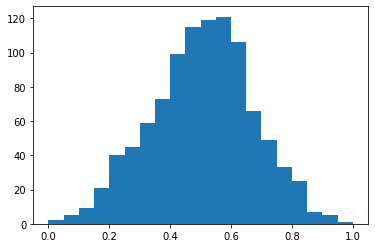

In [4]:
couplings = np.load("couplings.npy")
print(couplings.shape)
plt.hist(couplings, bins = 20)
plt.show()

In [5]:
"""
training set up
"""

kf = KFold(n_splits=5)
sp_cor=[]
rsq_score=[]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

features = np.load("features_catcoor.npy")
adj = np.load("adj.npy")
couplings = np.load("couplings.npy")

features = torch.tensor(features)
adj = torch.tensor(adj)
couplings = torch.tensor(couplings.reshape([couplings.shape[0],1]))


if torch.cuda.is_available():
    features=features.to(device)
    adj=adj.to(device)
    couplings=couplings.to(device)
    print("features and labels moved to GPU")
    
    


'\nif torch.cuda.is_available():\n    features=features.to(device)\n    adj=adj.to(device)\n    couplings=couplings.to(device)\n    print("features and labels moved to GPU")\n'

In [6]:
print(features.shape)

torch.Size([1000, 235, 196])


In [7]:
for train_idx, test_idx in kf.split(features):
    #print("%s %s" % (train, test))
    X_train, X_test, adj_train, adj_test, y_train, y_test = features[train_idx], features[test_idx], adj[train_idx], adj[test_idx], couplings[train_idx], couplings[test_idx]
    print("Training set are:")
    print(X_train.shape, y_train.shape)
    print("Test set are:")
    print(X_test.shape, y_test.shape)
    if torch.cuda.is_available():
        GCN_model = GCN(nfeat = 196, nhid1 = 100, nhid2 = 50, dropout = 0.1).to(device)
        print("CUDA is in use")
    else:
        GCN_model = GCN(nfeat = 196, nhid1 = 100, nhid2 = 50, dropout = 0.1)
    print("Model set to: %s" % (GCN))

    """check which parameter is not on gpu"""
    for name, param in GCN_model.named_parameters():
        if param.device.type != 'cuda':
            print('param {}, not on GPU'.format(name))
    '''train model'''

    torch_dataset = Data.TensorDataset(X_train, adj_train, y_train)
    loader = Data.DataLoader(
        dataset=torch_dataset,  # torch TensorDataset format
        batch_size=10,  # mini batch size
        shuffle=True,
    )

    optimizer = torch.optim.Adam(GCN_model.parameters(), lr=0.001)
    loss_func = torch.nn.MSELoss()
    #print(loader)
    train(150, 2, 'GCN.pth', loader)
    sp,rsq=test(GCN_model)
    sp_cor.append(sp)
    rsq_score.append(rsq)
print(sp_cor,rsq_score)

Training set are:
torch.Size([800, 235, 196]) torch.Size([800, 1])
Test set are:
torch.Size([200, 235, 196]) torch.Size([200, 1])
CUDA is in use
Model set to: <class 'models.GCN'>
step:  0


RuntimeError: Expected object of device type cuda but got device type cpu for argument #1 'self' in call to _th_mm

In [ ]:
    """result plot"""
    '''
    prediction=GCN_model(test_x,test_adj)
    plt.plot(prediction.data.cpu().numpy(), test_y.data.cpu().numpy(),'.')
    plt.ylabel('true values')
    plt.xlabel('predicted values')

    plt.hist(prediction.data.cpu().numpy(),bins=50,alpha=0.5,label='predicted')
    plt.hist(test_y.data.cpu().numpy(),bins=50,alpha=0.5,label='true')
    plt.legend(loc='upper right')
    plt.show()
    '''


In [ ]:
print("predictions_train is: %s" %(str(features.shape)))